In [1]:
import torch
import torch.nn as nn
import annmodel
import snnmodel
import matplotlib.pyplot as plt

def estimate_power(model, input_tensor, T=8):
    # 假设每次乘法和加法消耗的能量 (单位: Joules)
    # power_per_multiply = 1e-9  # 假设每次乘法操作消耗的能量
    # power_per_add = 1e-9  # 假设每次加法操作消耗的能量

    total_multiplications = 0
    total_additions = 0

    def count_ops(layer, x):
        nonlocal total_multiplications, total_additions
        if isinstance(layer, nn.Conv2d):
            # 计算卷积操作的乘法次数和加法次数
            out_size = x.shape[2:]  # 输出大小
            in_channels = layer.in_channels
            out_channels = layer.out_channels
            kernel_size = layer.kernel_size[0]
            total_multiplications += out_size[0] * out_size[1] * in_channels * kernel_size * kernel_size * out_channels
            total_additions += total_multiplications  # 每次乘法后都会有加法
        elif isinstance(layer, nn.Linear):
            # 计算全连接层的乘法次数和加法次数
            total_multiplications += x.shape[1] * layer.out_features
            total_additions += total_multiplications  # 每次乘法后都会有加法
        return x

    def forward_hook(module, input, output):
        # 钩子函数，用于计数每一层的操作
        count_ops(module, input[0])

    # 给每一层添加钩子函数
    hooks = []
    for layer in model.modules():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    # 前向传播
    model(input_tensor)

    # 删除钩子
    for hook in hooks:
        hook.remove()
    
    return total_multiplications, total_additions

T = 4
snn_mul_num = []
snn_add_num = []
ann_mul_num = []
ann_add_num = []

for segment in range(2, 5):
    input_tensor = torch.randn(64, segment**2, 3, 32, 32)
    snn = snnmodel.DPN(segment=segment, T=T)
    ann = annmodel.DPN(segment=segment)

    # 估算功耗
    mul, add = estimate_power(snn, input_tensor)
    snn_mul_num.append(mul)
    snn_add_num.append(add)

    mul, add = estimate_power(ann, input_tensor)
    ann_mul_num.append(mul)
    ann_add_num.append(add)

/home/hyqm/anaconda3/envs/snn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


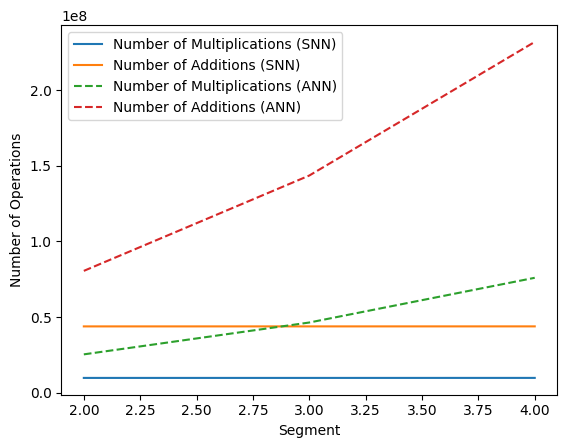

In [2]:
# 绘制图像
plt.figure()
plt.plot(range(2, 5), snn_mul_num, label='Number of Multiplications (SNN)')
plt.plot(range(2, 5), snn_add_num, label='Number of Additions (SNN)')
plt.plot(range(2, 5), ann_mul_num, label='Number of Multiplications (ANN)', linestyle='--')
plt.plot(range(2, 5), ann_add_num, label='Number of Additions (ANN)', linestyle='--')
plt.xlabel('Segment')
plt.ylabel('Number of Operations')
plt.legend()
plt.show()